In [ ]:
!pip install pymilvus
!pip -q install langchain-groq
!pip -q install -U langchain_community tiktoken langchainhub
!pip -q install langchain huggingface_hub
!pip -q install PyPDF2 pypdf sentence_transformers
!pip install --quiet langchain-google-genai
!pip install langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 kB 792.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.64.1
    Uninstalling grpcio-1.64.1:
      Successfully uninstalled grpcio-1.64.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -qU semantic-router==0.0.37

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
import json

# API KEY Access

In [ ]:
import os

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
from semantic_router.encoders import OpenAIEncoder

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")

encoder = OpenAIEncoder(name="text-embedding-3-small")

# Access Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from glob import glob
from langchain.document_loaders import PyPDFLoader
from google.colab import userdata

# Chunk

In [ ]:
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.utils.logger import logger
from semantic_router.encoders import HuggingFaceEncoder

logger.setLevel("WARNING")  # reduce logs from splitter
# encoder.score_threshold = 0.24
splitter = RollingWindowSplitter(
    encoder=encoder,
    dynamic_threshold=True,
    min_split_tokens=200,
    max_split_tokens=1000,
    window_size=2,
    plot_splits=True,  # set this to true to visualize chunking
    enable_statistics=True  # to print chunking stats
)

# Helping Tools

In [ ]:
def metadata_creating_bold_head(docx,title,index):

  metadata = []
  for i, s in enumerate(docx):
      if i == 0:
        prechunk = ""
      else:
        prechunk = docx[i-1].content
      print(i)
      if i+1 == len(docx):
        postchunk = ""
      else:
        postchunk = docx[i+1].content
      metadata.append({
          "id": index+i,
          "title": title,
          "content": s.content,
          "prechunk": prechunk,
          "postchunk": postchunk,
      })
  return metadata

In [ ]:
def upload_data(collection_name,uri,milvus_data):
  client = MilvusClient(uri)
  start = time.time()

  res = client.insert(
      collection_name,
      data=milvus_data
  )
  end = time.time()
  print("------------")
  print(end-start)
  print("------------")
  print(res)

In [ ]:
from pymilvus import MilvusClient, DataType
import time


def creating_collection(collection_name,uri):
  length= 60
  client = MilvusClient(uri)

  index_params = client.prepare_index_params()

  index_params.add_index(
      field_name="id",
      index_type="STL_SORT"
  )

  index_params.add_index(
      field_name="vector",
      index_type="IVF_PQ",
      metric_type="COSINE",
      params={ "nlist": length}
  )
  start = time.time()
  client.create_collection(
      collection_name,
      index_params=index_params,
      dimension=1536
  )
  end = time.time()


  res = client.get_load_state(
      collection_name
  )

  print('----------')
  print(end-start)
  print('----------')
  print(res)

In [ ]:
# import os
# from google.colab import userdata

# uri=userdata.get("MILVUS_URI")
# collection_name = 'child_diagnosis'
# creating_collection(collection_name,uri)

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: f7c377062f014900ab7b906409ff4acb
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created collection: child_diagnosis
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created an index on collection: child_diagnosis


----------
4.425302743911743
----------
{'state': <LoadState: Loaded>}


In [ ]:
def build_chunk(title: str, content: str):
    return f"# {title}\n{content}"
def milvusPrep(metadata, encoder):
  data = []
  batch_size = 1

  for i in range(0, len(metadata), batch_size):
    i_end = min(len(metadata), i+batch_size)
    # get batch of data
    metadata_batch = metadata[i:i_end]
    # generate unique ids for each chunk
    for n in metadata_batch:
      id = n["id"]
    # id = metadata_batch['id']
    # get text content to embed
    content = [
        build_chunk(
            title=x["title"], content=x["content"]
        ) for x in metadata_batch
    ]
    # embed text
    vector = encoder(content)
    # add to Pinecone

    # (ids, embeds, metadata_batch)
    data.append({"id":int(id), "vector":vector[0], "metadata":metadata_batch})
  return data

# The Main Data

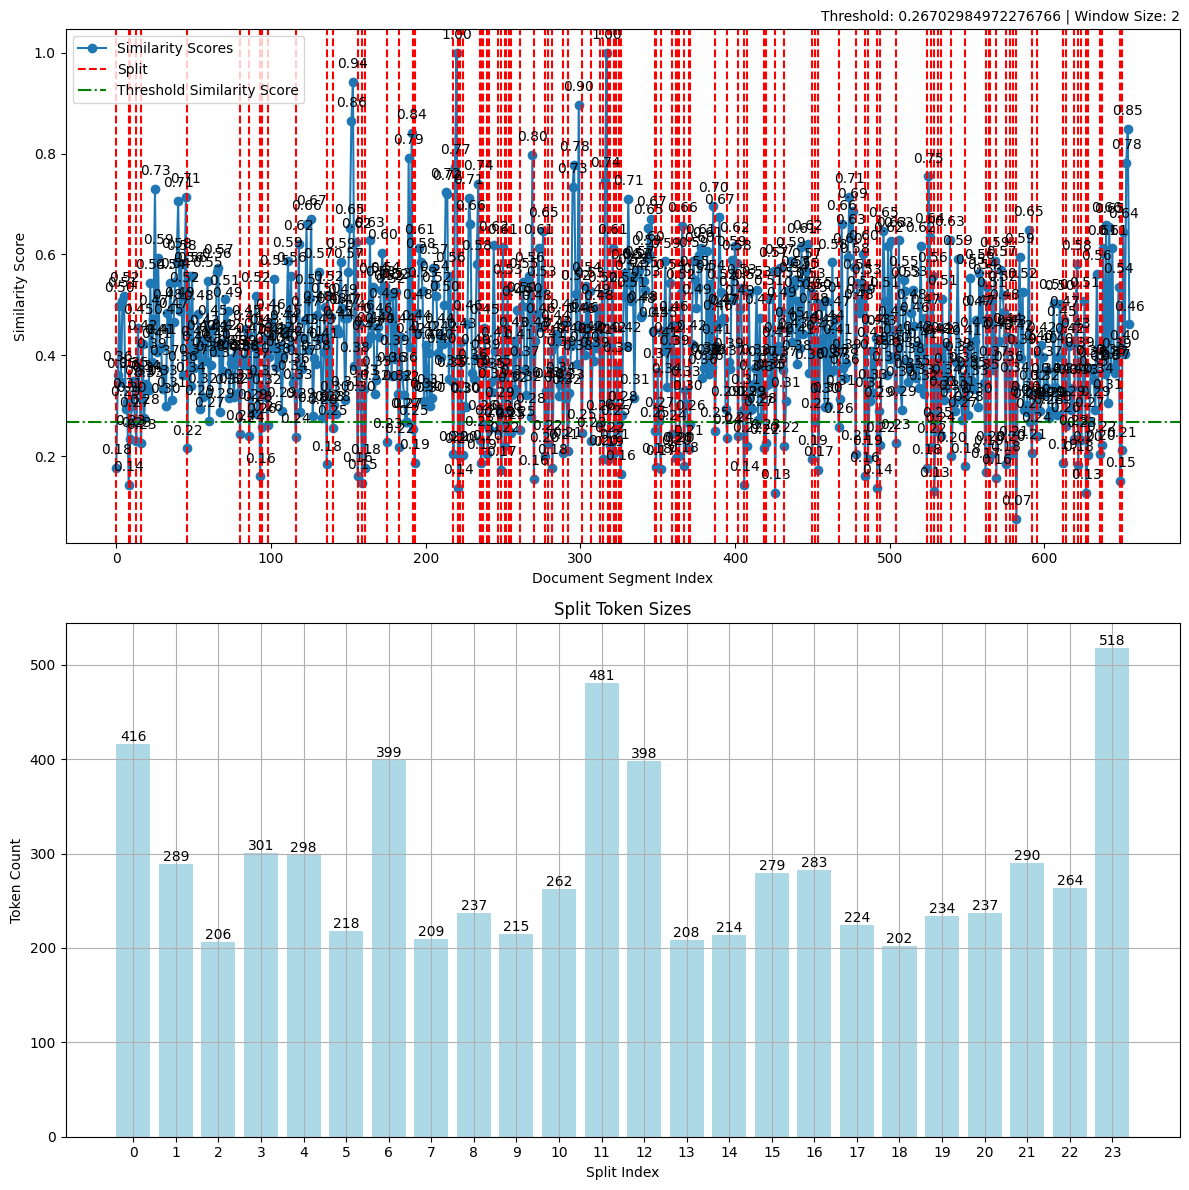

Splitting Statistics:
  - Total Documents: 657
  - Total Splits: 24
  - Splits by Threshold: 23
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 202
  - Maximum Token Size of Split: 518
  - Similarity Split Ratio: 0.96
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
Acknowledgement The guidelines development group would like to thank the Armed Forces Col lege of   Medicine for taking the initiative to start developing national guidelines. We are  grateful to the authors of the ISPAD 2018 clinical practice consensus guidelines on DKA in Children and Adol escents, which were the basis for our national guidelines. We would like to acknowledge the invaluable help of Prof Joseph Wolfsdorf for giving his expert opinion that helped in clarifying some of the points  encountered in the management in relation to fluid and insulin therapy (personal communication). We acknowledge the Diabetes Endocrine and Metabolism Pediatric Unit  at Cairo Universi

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: db735c2396774a3a8f45d82edcffafe1


------------
1.6525166034698486
------------
{'insert_count': 24, 'ids': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], 'cost': 0}


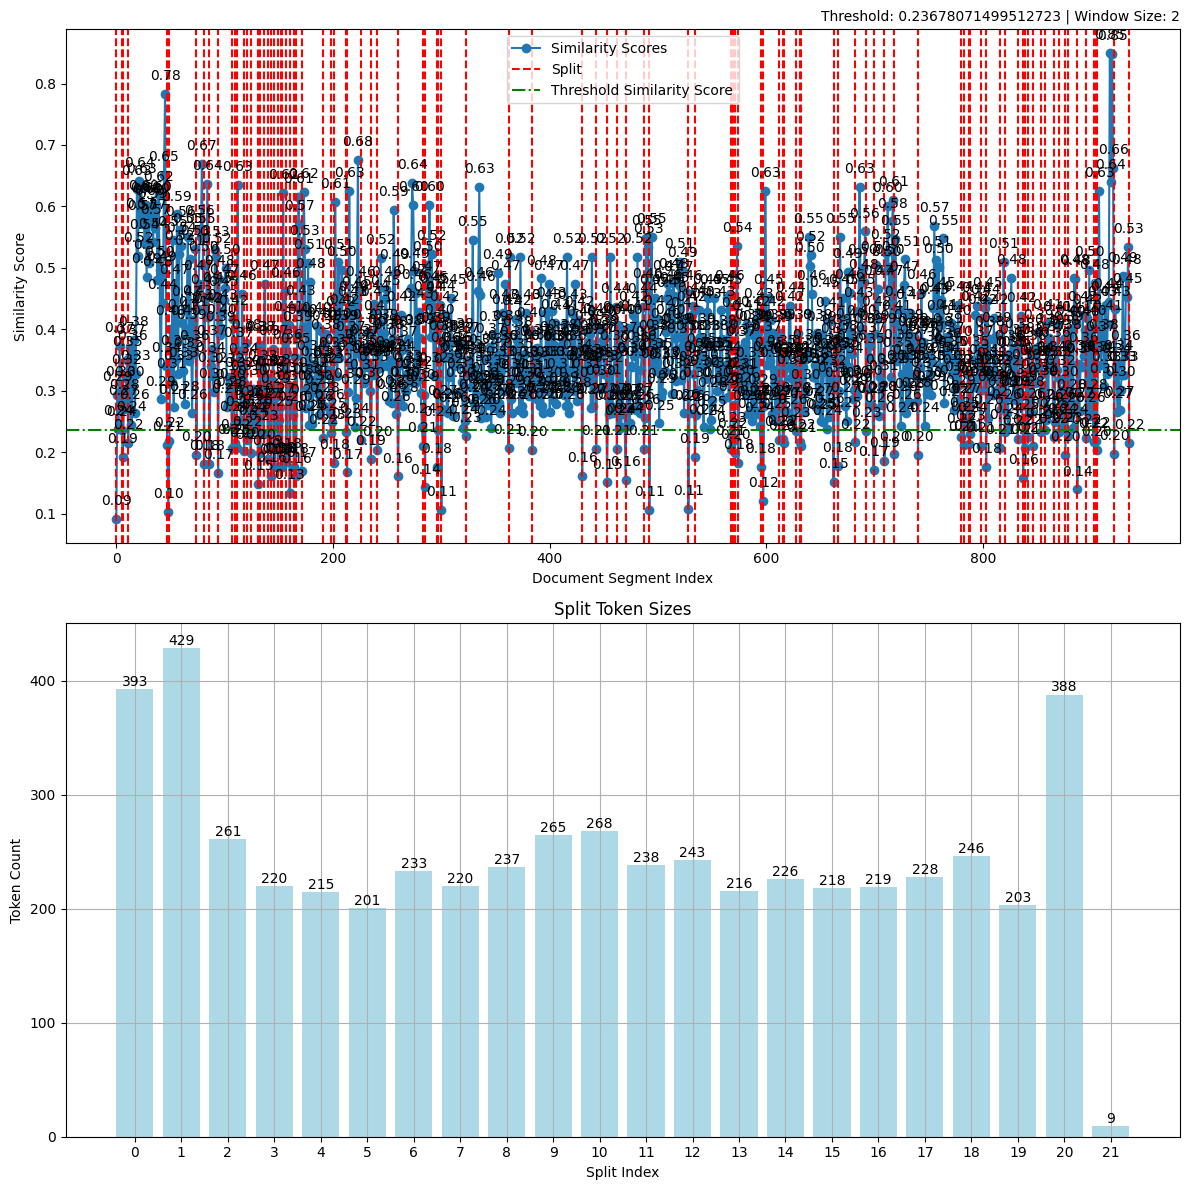

Splitting Statistics:
  - Total Documents: 937
  - Total Splits: 22
  - Splits by Threshold: 21
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 9
  - Maximum Token Size of Split: 429
  - Similarity Split Ratio: 0.95
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
practice. These diagnostic methods may be classified as invasive, which require endoscopy to obtain biopsies of gastric tissues, and non -invasive. The invasive methods include histologica l examination, culture, urease test and molecular methods, while the non - invasive methods include urea breath testing, serology and stool antigen testing.13,14&15 Diagnosis in children requires the use of invasive methods with endoscopy. Non - invasive asses sment methods are reserved to determine whether H. pylori has been eradicated.7 The test and treat strategy involve  delivery of H. pylori eradication therapy based on positive results of a non -invasive test, such as the H. pylori breath test

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 01469c18db2049dc99be25b3b21c70d3


------------
1.405463695526123
------------
{'insert_count': 22, 'ids': [3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021], 'cost': 0}


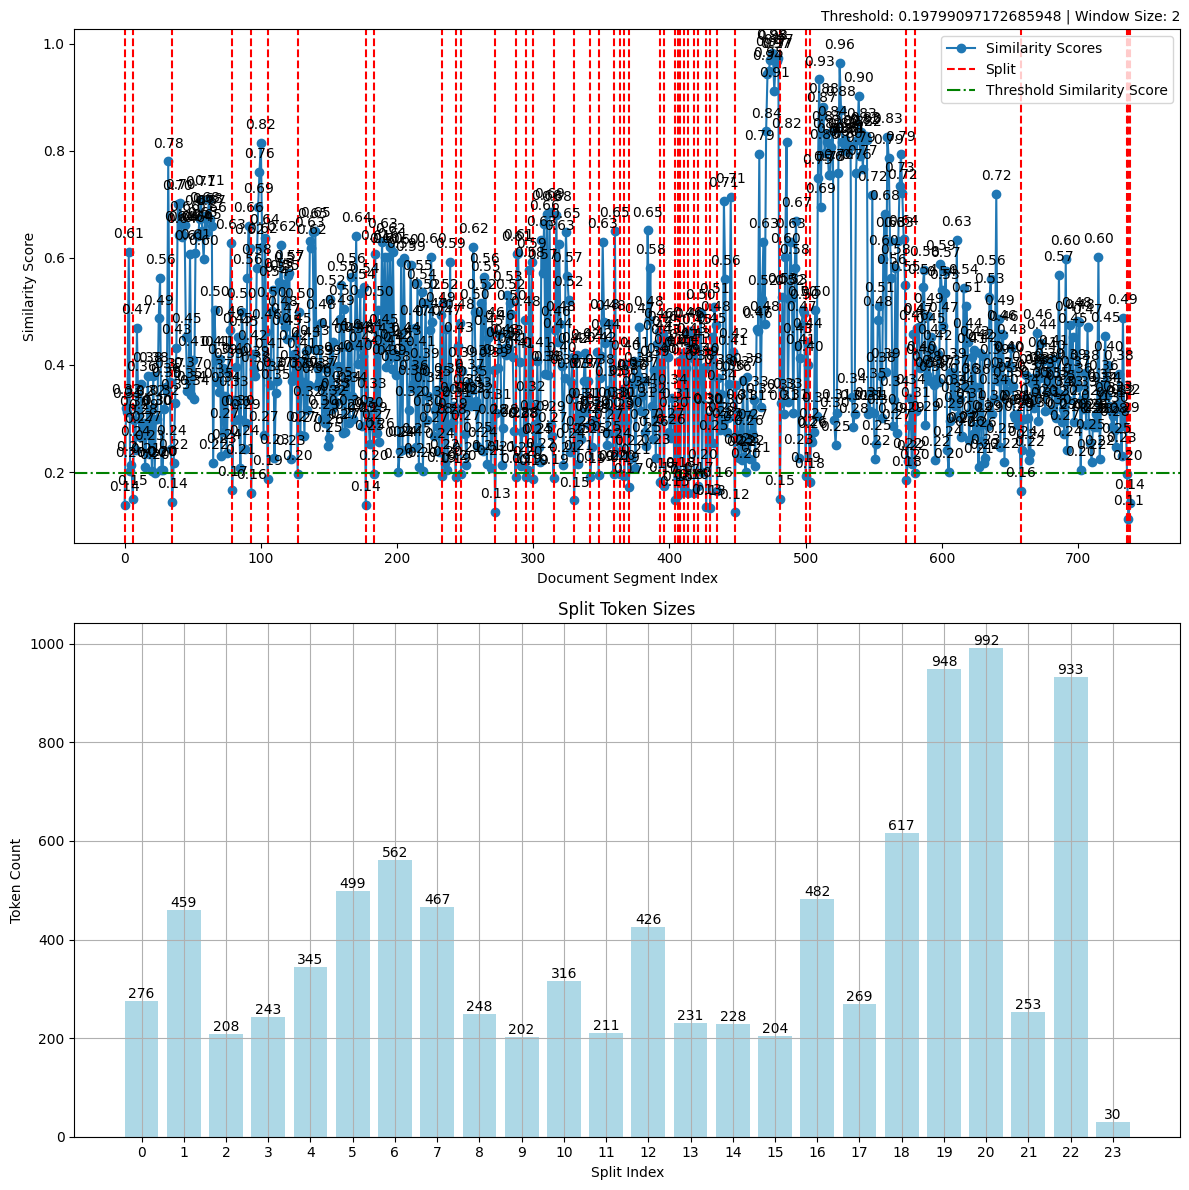

Splitting Statistics:
  - Total Documents: 740
  - Total Splits: 24
  - Splits by Threshold: 21
  - Splits by Max Chunk Size: 2
  - Last Split: 1
  - Minimum Token Size of Split: 30
  - Maximum Token Size of Split: 992
  - Similarity Split Ratio: 0.88
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
(Damietta) 3 Dr. NahedFahmyHelal  Prof. of Pediatrics & Neonatology, Cairo University 3 1. INTRODUCTION AND B ACKGROUND Low birth weight infant ( LBW , defined as a birth -weight <2500 grams ). The global prevalence of LBW is 15.5%, which means that about 20.6 million such infants are born each year, 96.5% of them are in developing countries. LBW subgroups include  those with  very low birth -weight ( VLBW , defined as a birth -weight <1500 grams) and extr emely low birth -weight ( ELBW , defined as a birth weight <1000 grams) [1]. LBW can be a consequence of a preterm birth ( PT, defined as a birth before 37 completed weeks of gestation), or due to a small size for gestational

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: cc350675db2c42b391081e4d6e9b91c8


------------
1.6510093212127686
------------
{'insert_count': 24, 'ids': [4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023], 'cost': 0}


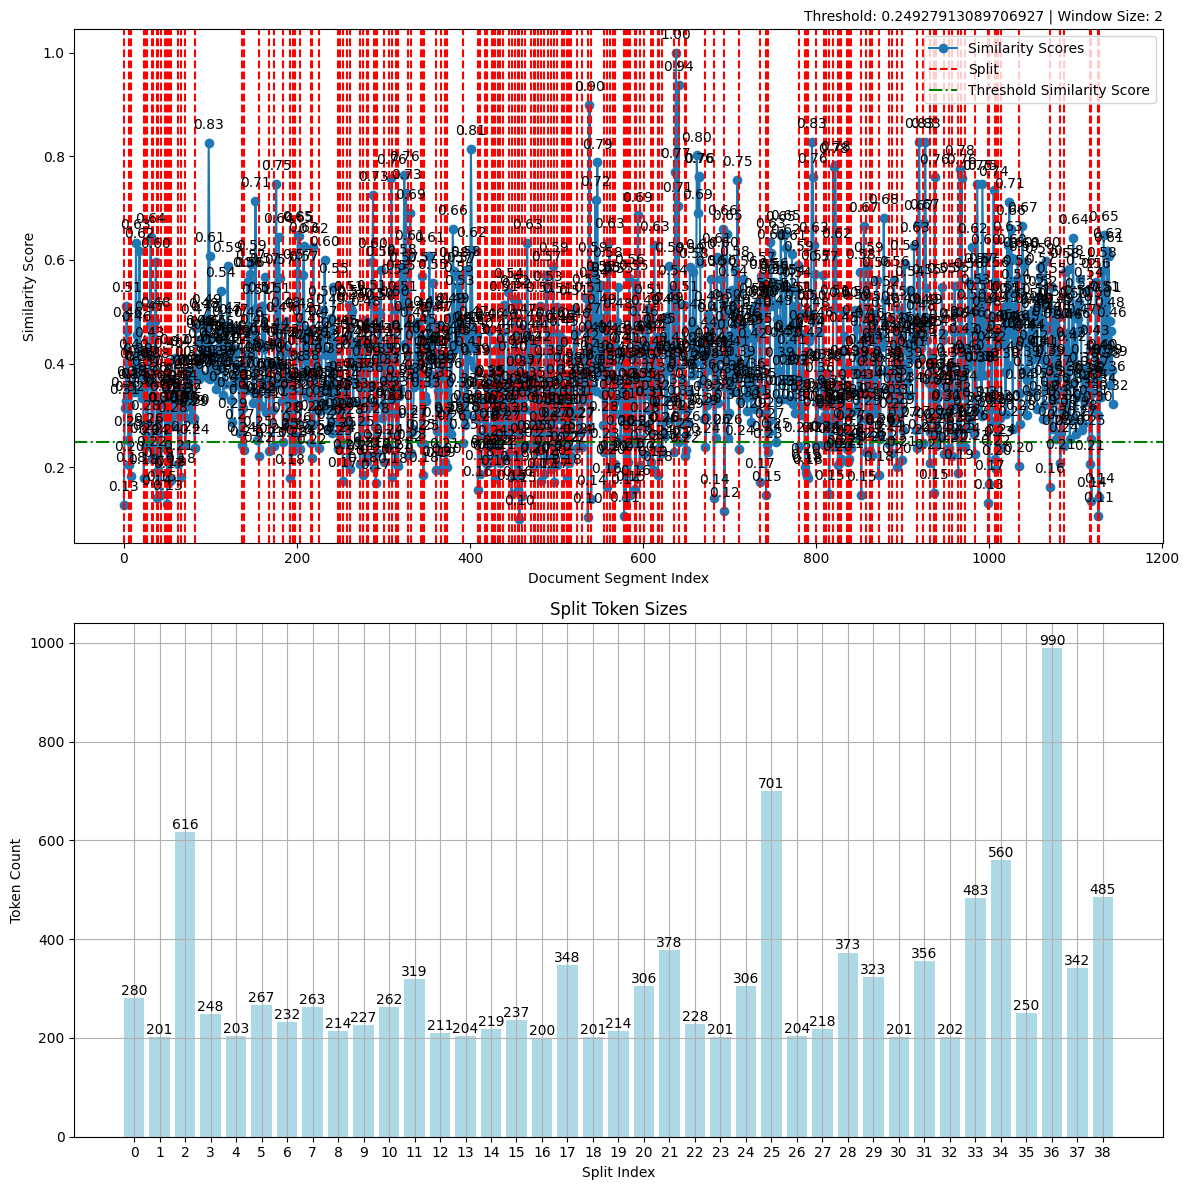

Splitting Statistics:
  - Total Documents: 1145
  - Total Splits: 39
  - Splits by Threshold: 37
  - Splits by Max Chunk Size: 1
  - Last Split: 1
  - Minimum Token Size of Split: 200
  - Maximum Token Size of Split: 990
  - Similarity Split Ratio: 0.95
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
7- EXTERNAL REVIEW AND CONSULTATION PROCESS .... Error! Bookmark not defined. 8- PLAN FOR SCHEDULED REVIEW AND UPDATE  Error! Bookmark not defined. 9- LIST OF FUNDING SOURCES  ................................ ... Error! Bookmark not defined. 10- ADAPTATION PROCESS METHODOLOGY  ....... Error! Bo okmark not defined. 11- IMPLEMENTATION CONSIDERATIONS AND TOOLS  .. Error! Bookmark not defined. 12- GLOSSARY FOR UNFAMILIAR TERMS (AFTER ADAPTE)  . Error! Bookmark not defined. 13- REFERENCES  ................................ .......................... Error! Bookmark not defined. 14- APPENDICES  ................................ ...........

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 2ce06d8f7c65487d990eaa19530beb64


------------
1.9005296230316162
------------
{'insert_count': 39, 'ids': [5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038], 'cost': 0}


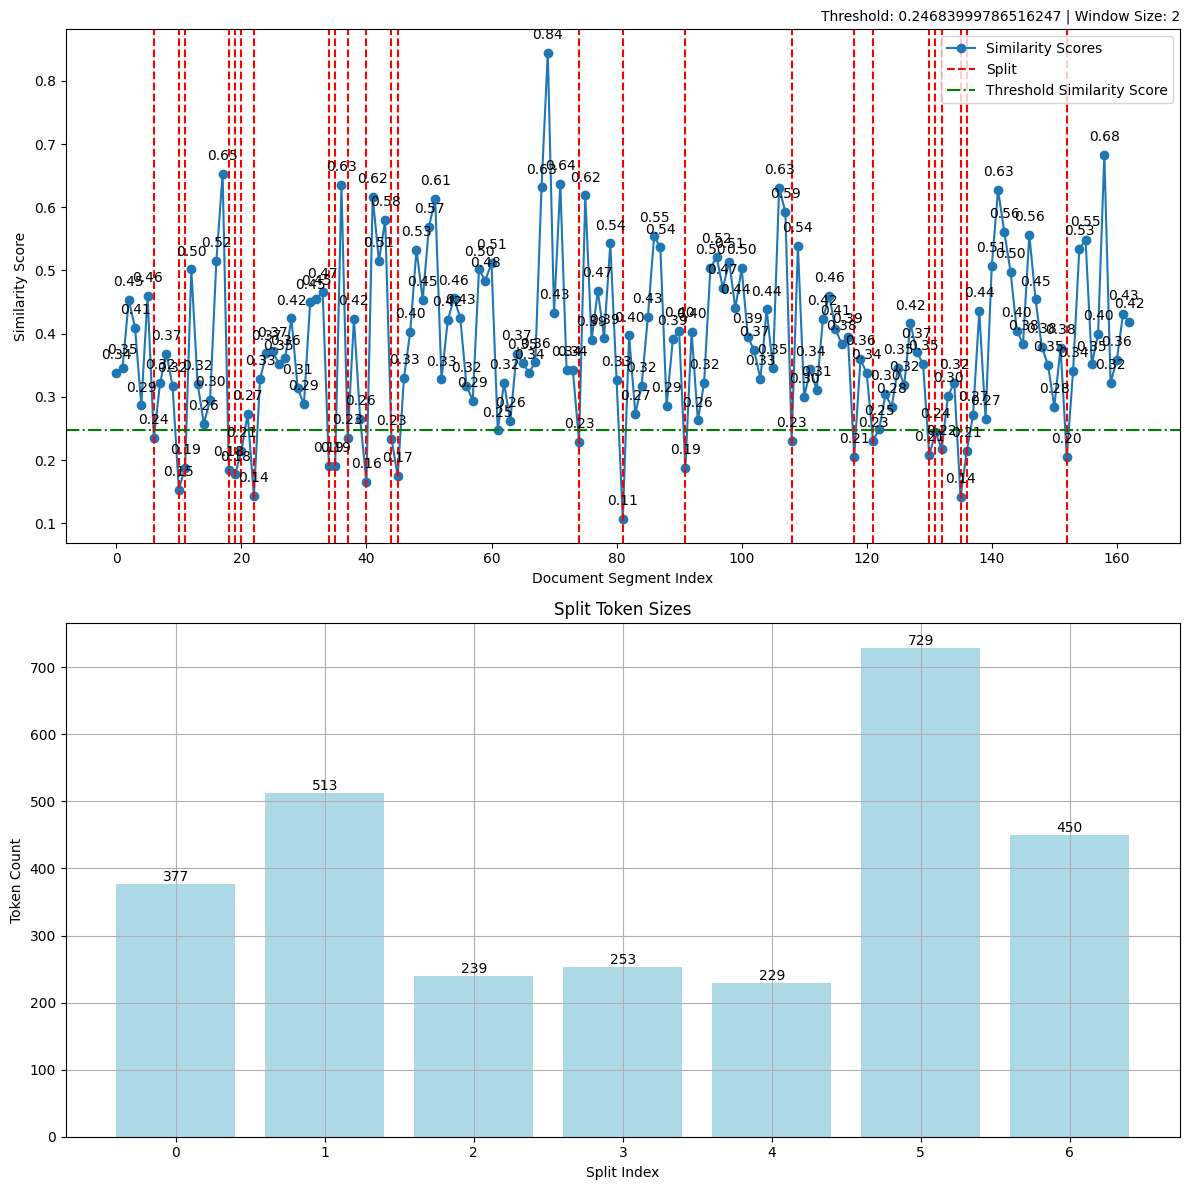

Splitting Statistics:
  - Total Documents: 164
  - Total Splits: 7
  - Splits by Threshold: 6
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 229
  - Maximum Token Size of Split: 729
  - Similarity Split Ratio: 0.86
0
1
2
3
4
5
6
There is no standard definition for refractory or resistant FMF however, the recent guidelines stated that FMF can be consid ered resistant to treatment if: 1- The patient continued to have ≥ one attack per month despite the maximally tolerated continuous colchicine dose for ≥ 6 months. 2- Persistent subclinical inflammation that is  a risk factor for amyloidosis. 3- If the patient developed renal amyloidosis. In case of uncontrolled disease, the second line drugs, the biological agents, should be added. Anti -interleukin I (anti -IL-1) biological drugs are recommended in the patients w ith FMF. Management of the acute attacks includes  continuation of the colchicine therapy on the same dose and adding nonsteroidal anti -infl

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 1620067c46744c518c4b010dbe1146e9


------------
1.090087890625
------------
{'insert_count': 7, 'ids': [6000, 6001, 6002, 6003, 6004, 6005, 6006], 'cost': 0}


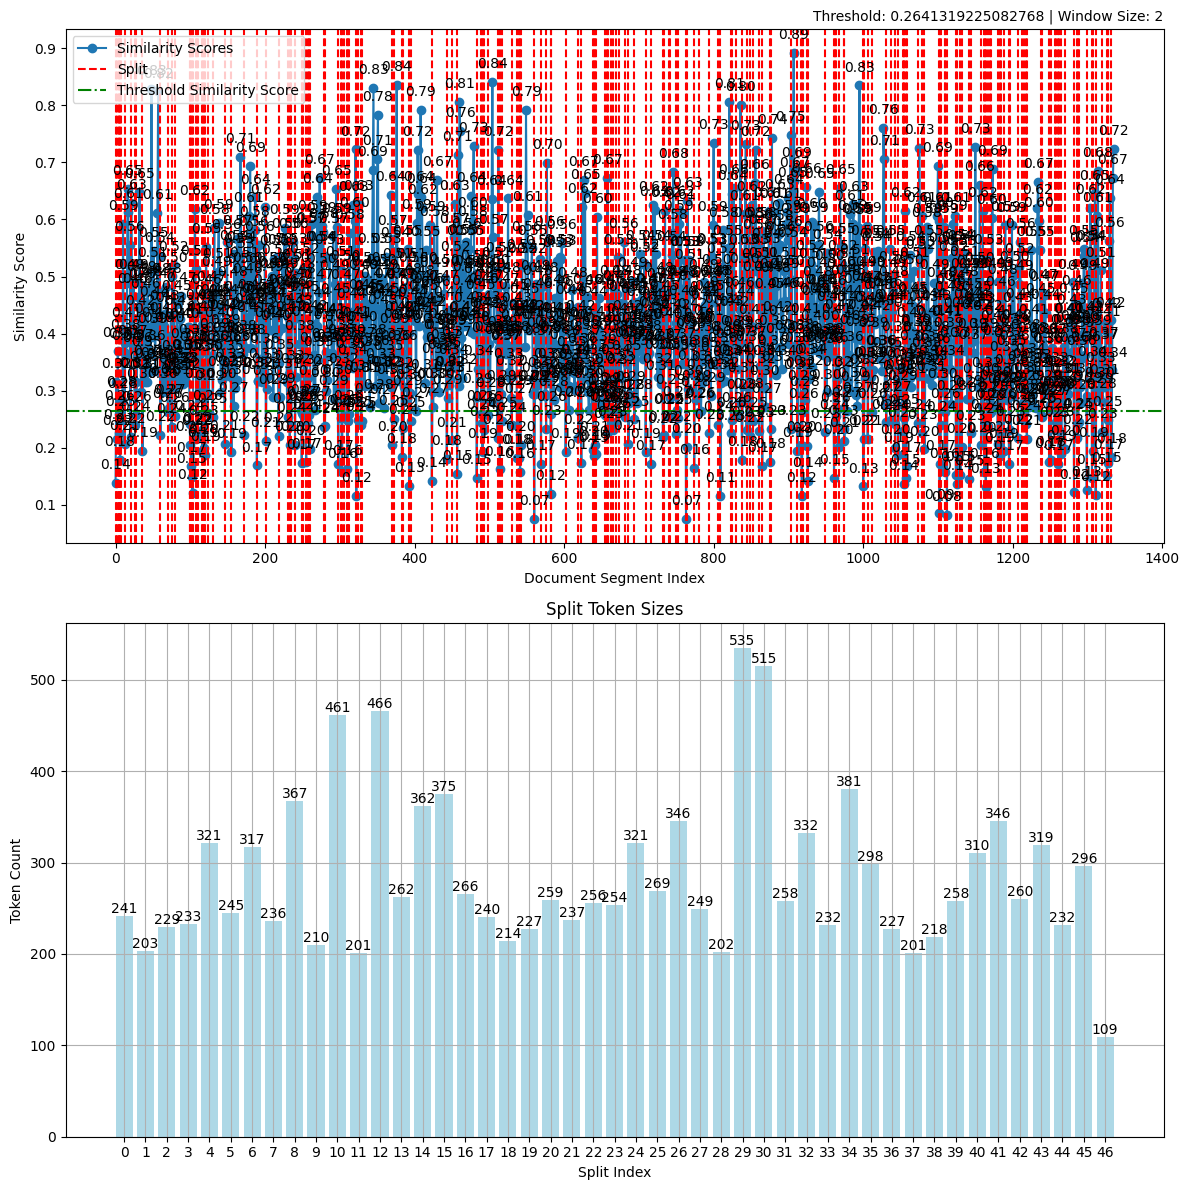

Splitting Statistics:
  - Total Documents: 1337
  - Total Splits: 47
  - Splits by Threshold: 46
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 109
  - Maximum Token Size of Split: 535
  - Similarity Split Ratio: 0.98
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
4 University Prof. Laila M. Sherif  Professor of Pediatrics, Zagazig University Prof. Marwa Zakaria  Ass. Professor of Pediatrics, Zagazig University ICU group Prof. Hanan Ibrahim  Professor of Pediatrics, Ain  Shams University Cardiology group Prof. Alyaa Kotby  Professor of Pediatrics, Ain Shams University Prof. Mona El Ganzoury  Professor of Pediatrics, Ain Shams University Immunology group Prof. Sanaa Abd Elrahman  Professor of Pediatrics, Pikeville Osteopathic School of medicine USA , and Ain Shams University. Dr. Hanan M. Abd El Latee f Lecture r of Pediatrics, Ain Shams University 5 What is new in thi

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 5adec8667d544a968cb1d50dc6277fd5


------------
1.9243671894073486
------------
{'insert_count': 47, 'ids': [7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046], 'cost': 0}


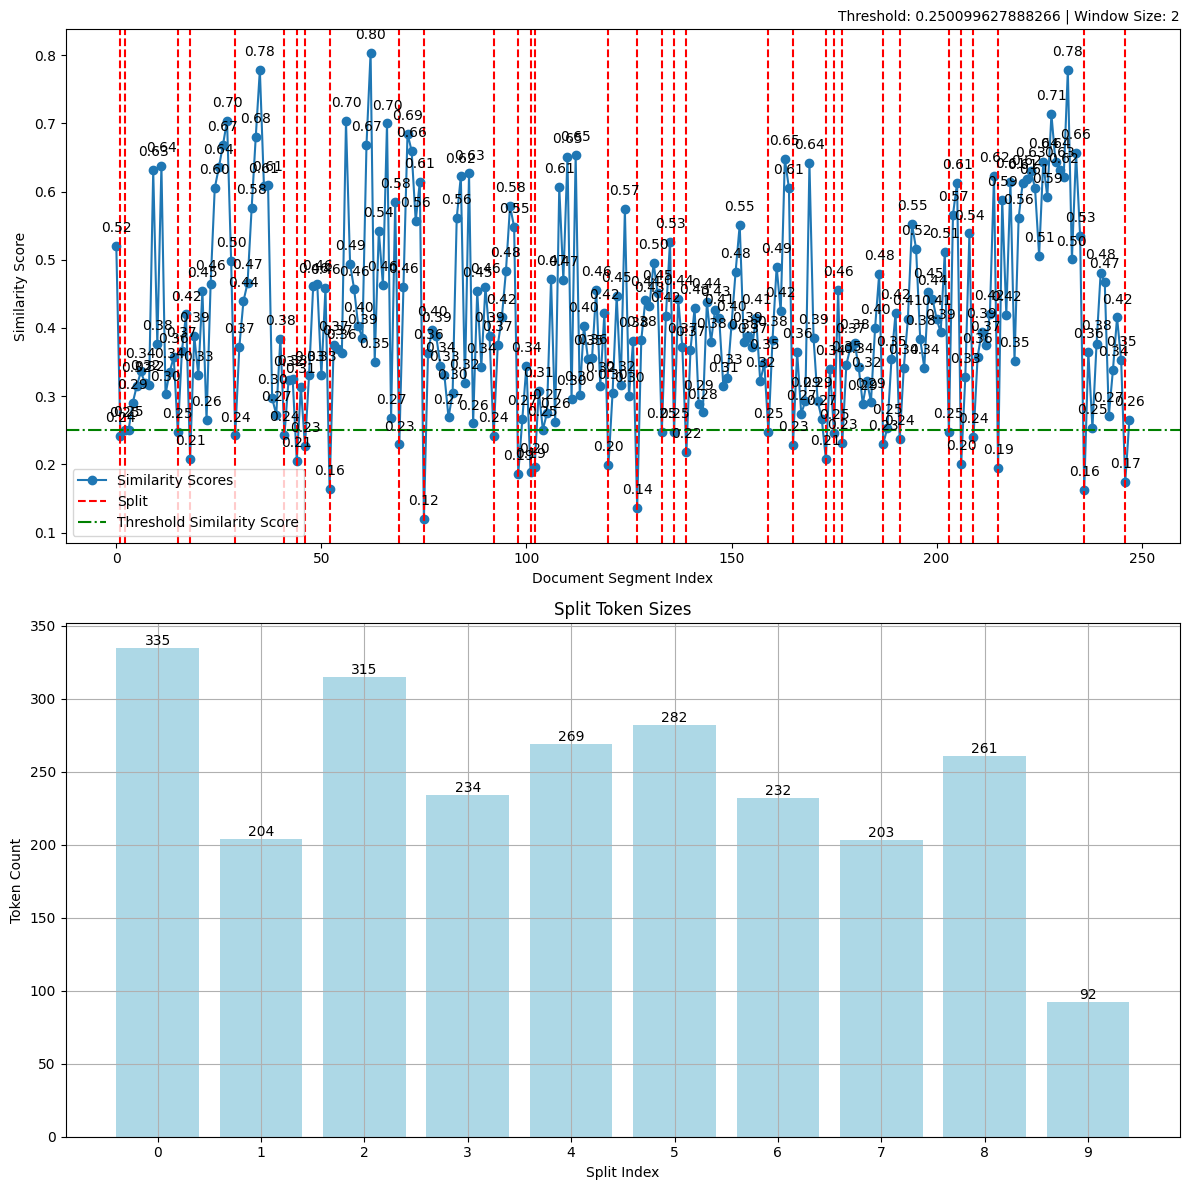

Splitting Statistics:
  - Total Documents: 249
  - Total Splits: 10
  - Splits by Threshold: 9
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 92
  - Maximum Token Size of Split: 335
  - Similarity Split Ratio: 0.90
0
1
2
3
4
5
6
7
8
9
OR Anesthetic doses of either thiopental, midazolam, pentobarbital, or propofol (all with continuous EEG monitoring  in the PICU ) Disclaimer: This clinical guideline is designed to help  clinicians by providing framework for evaluating and treating  children with acute convulsion . It is not intended to replace a clinician’s medical judgment. The clinical conditions intended  by this guideline may  not fit or work with all patients. As early as possible (Level 1B – Grade A and Level 2 – Grade B) - Better by trained personnel (medical / paramedical) or by caregiver. - Drugs of Choic e: - Midazolam: o Intra -muscular: 13 – 40 kg:  5 mg >40 kg:  10 mg o Buccal:    0.5 mg/kg (max 10 mg) - Diazepam: o Per-rectal: 2 – 5 year

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 5332e2128181481cbf4df75aa6d2396e


------------
1.091874361038208
------------
{'insert_count': 10, 'ids': [8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009], 'cost': 0}


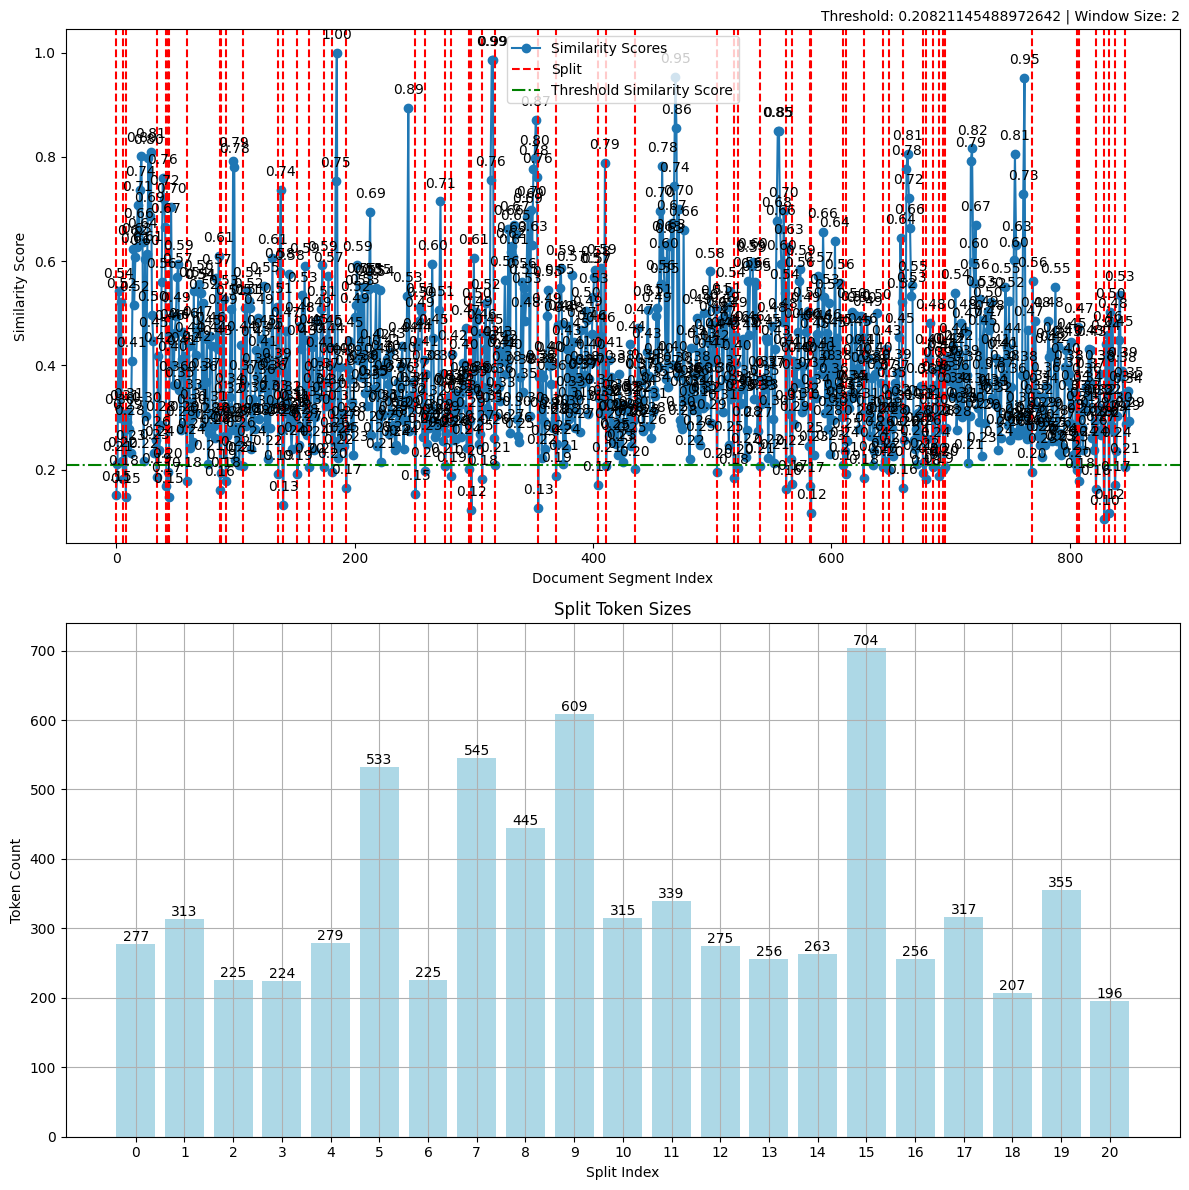

Splitting Statistics:
  - Total Documents: 852
  - Total Splits: 21
  - Splits by Threshold: 20
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 196
  - Maximum Token Size of Split: 704
  - Similarity Split Ratio: 0.95
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Page | 4 RECOMMENDATIONS CPGL Source  Recommendation  Evidence level Risk factors UTIs in children AAUS 2015  The following conditions raise suspicion of UTI and serious underlying pathology • Recurrent fever of uncertain origin. • History suggesting previous UTI or confirmed previous UTI. • Poor urine flow or dysfunctional voiding. • Constipation and bladder bowel dysfunction (BBD). • Antenatally diagnosed renal abnormality (fetal US). • Family history of vesicoureteric reflux (VUR) or renal disease. • Abnormal back& spine. • Abnormal external genitalia (phimosis, fused labia) *N.B. oxyuris, being so common in Egypt and developing countries, is to be considered a risk factor of UTI in

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: a2d78f9cad8d4eafa7f1a774c2ab5355


------------
1.6354899406433105
------------
{'insert_count': 21, 'ids': [9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019, 9020], 'cost': 0}


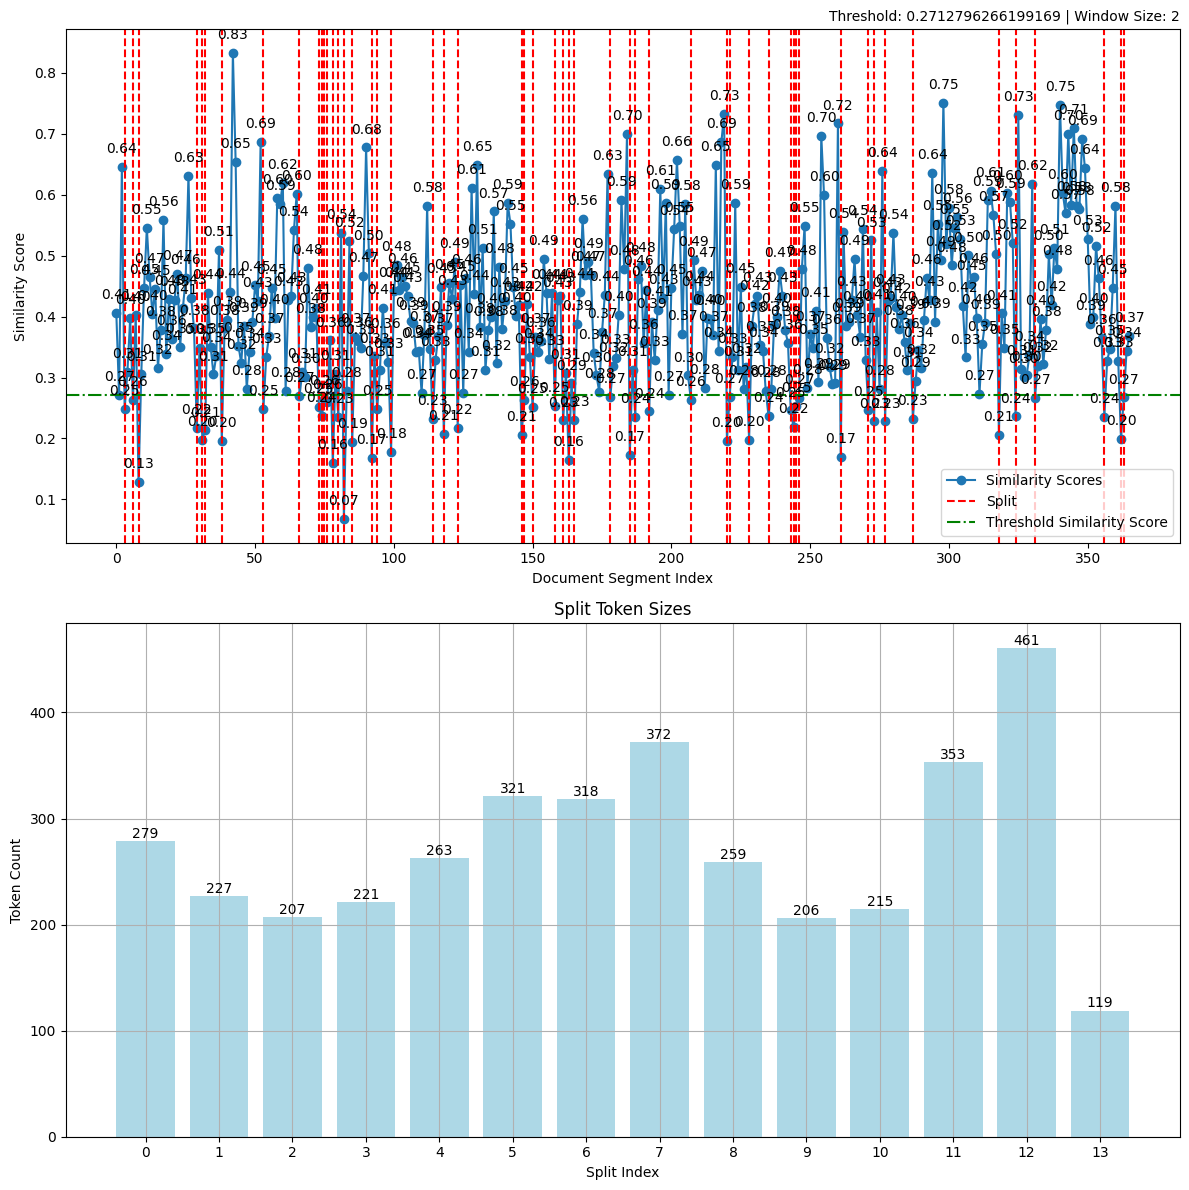

Splitting Statistics:
  - Total Documents: 367
  - Total Splits: 14
  - Splits by Threshold: 13
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 119
  - Maximum Token Size of Split: 461
  - Similarity Split Ratio: 0.93
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Egypt. Prof. Mervat Abdallah Hesham  Professor of Pediatrics, P ediatric Hematology and Oncology U nit, Zagazig university, Egypt. Prof. Niveen Salama   Associate Professor of Pediatrics, Cairo University,  Cairo,  Egypt. Dr. Nouran  Yousef  Salah  Lecturer of Pediatrics, pe diatric Diabetes, Endocrinology and M etabolism unit,  Ain Shams University, AFCM Prof. Rasha Abdel -Raouf  Professor of Pediatrics  and Pediatric Hematology , Cairo University, AFCM Dr Dr. Sara Makkeya h  Lecturer of Pediatrics, Pediatric Hematology and Oncology Unit, Ain Shams University , Cairo,  Egypt . Prof. Sherein  Abdelhamid Shalaby  Professor of Pediatrics, head of Pediatrics department. Helwan University Prof. Sonia Adolf  Ha

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 249c2f2f0f7946b5991ae0fb99426e56


------------
1.3619654178619385
------------
{'insert_count': 14, 'ids': [10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013], 'cost': 0}


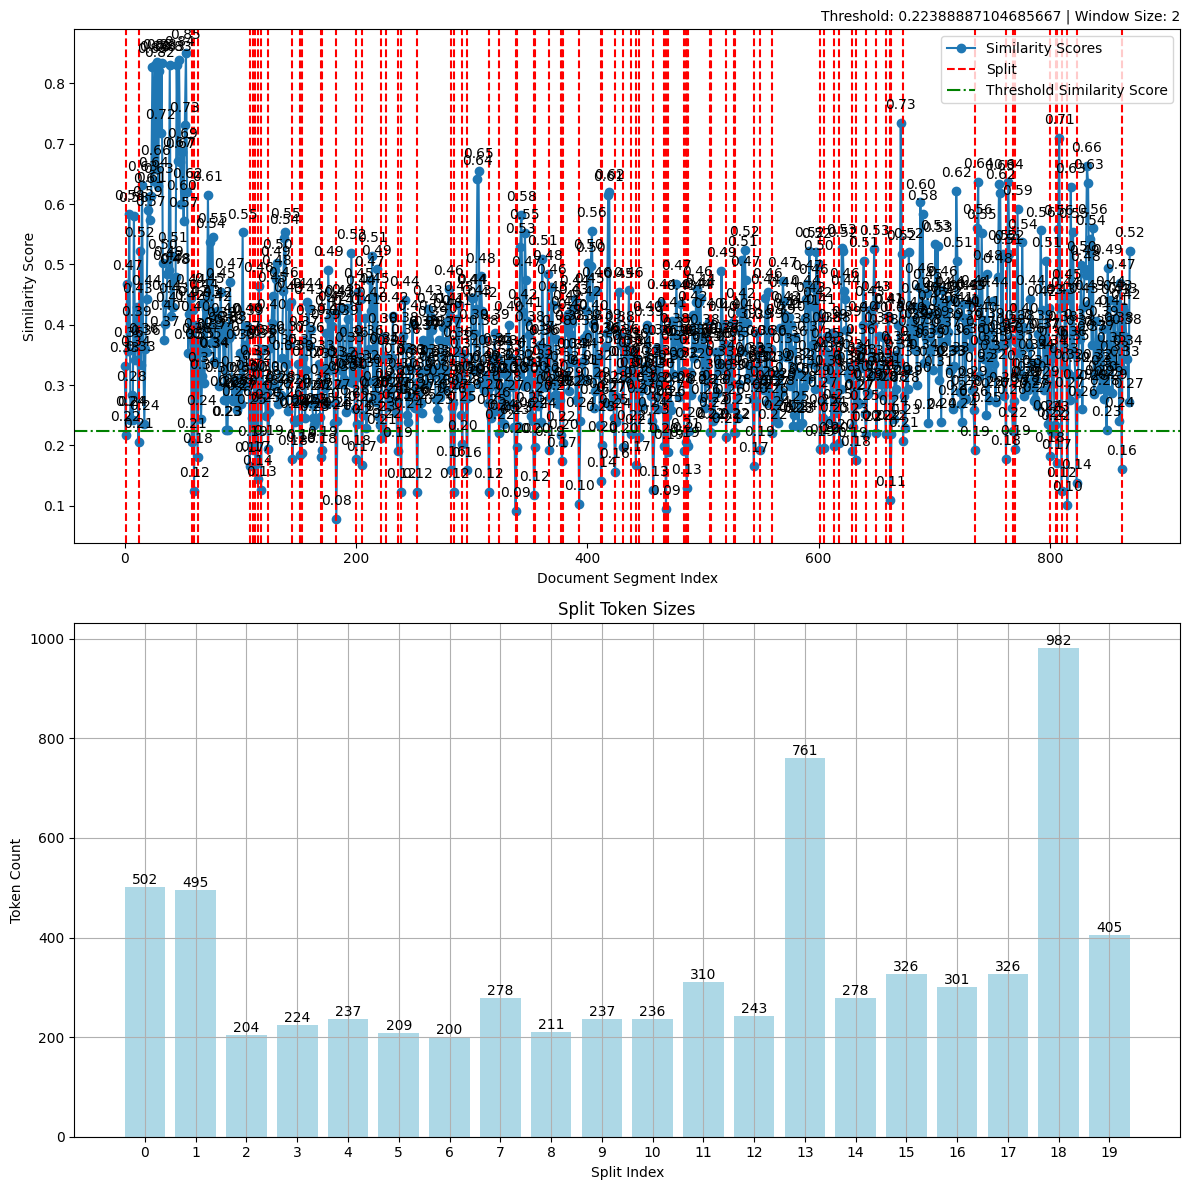

Splitting Statistics:
  - Total Documents: 871
  - Total Splits: 20
  - Splits by Threshold: 18
  - Splits by Max Chunk Size: 1
  - Last Split: 1
  - Minimum Token Size of Split: 200
  - Maximum Token Size of Split: 982
  - Similarity Split Ratio: 0.90
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Evidence C Weak recommendatio n Austral asian Bronchiolitis Guideline 2016 The major factors which were predictive were fever, cough, tachypnea, retractions, and wheeze. In infants presenting to hospital what factors in history and physical examination contribute to diagnosis  of bronchiolitis ? 1b Evidence C Grade : conditional  Austral asian Bronchiolitis Guideline 2016 Clinicians should consider as risk factors for more serious illness: gestational age less than 37 weeks; chronological age at presentation less than 10 weeks; exposure to cigarette smoke; breast feeding for less than two months; failure to thrive; having chronic lung disease; having chronic heart and/or chronic neurologi

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 573daa24edb84898bd02834d0b6ac6ca


------------
1.3703968524932861
------------
{'insert_count': 20, 'ids': [11000, 11001, 11002, 11003, 11004, 11005, 11006, 11007, 11008, 11009, 11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017, 11018, 11019], 'cost': 0}


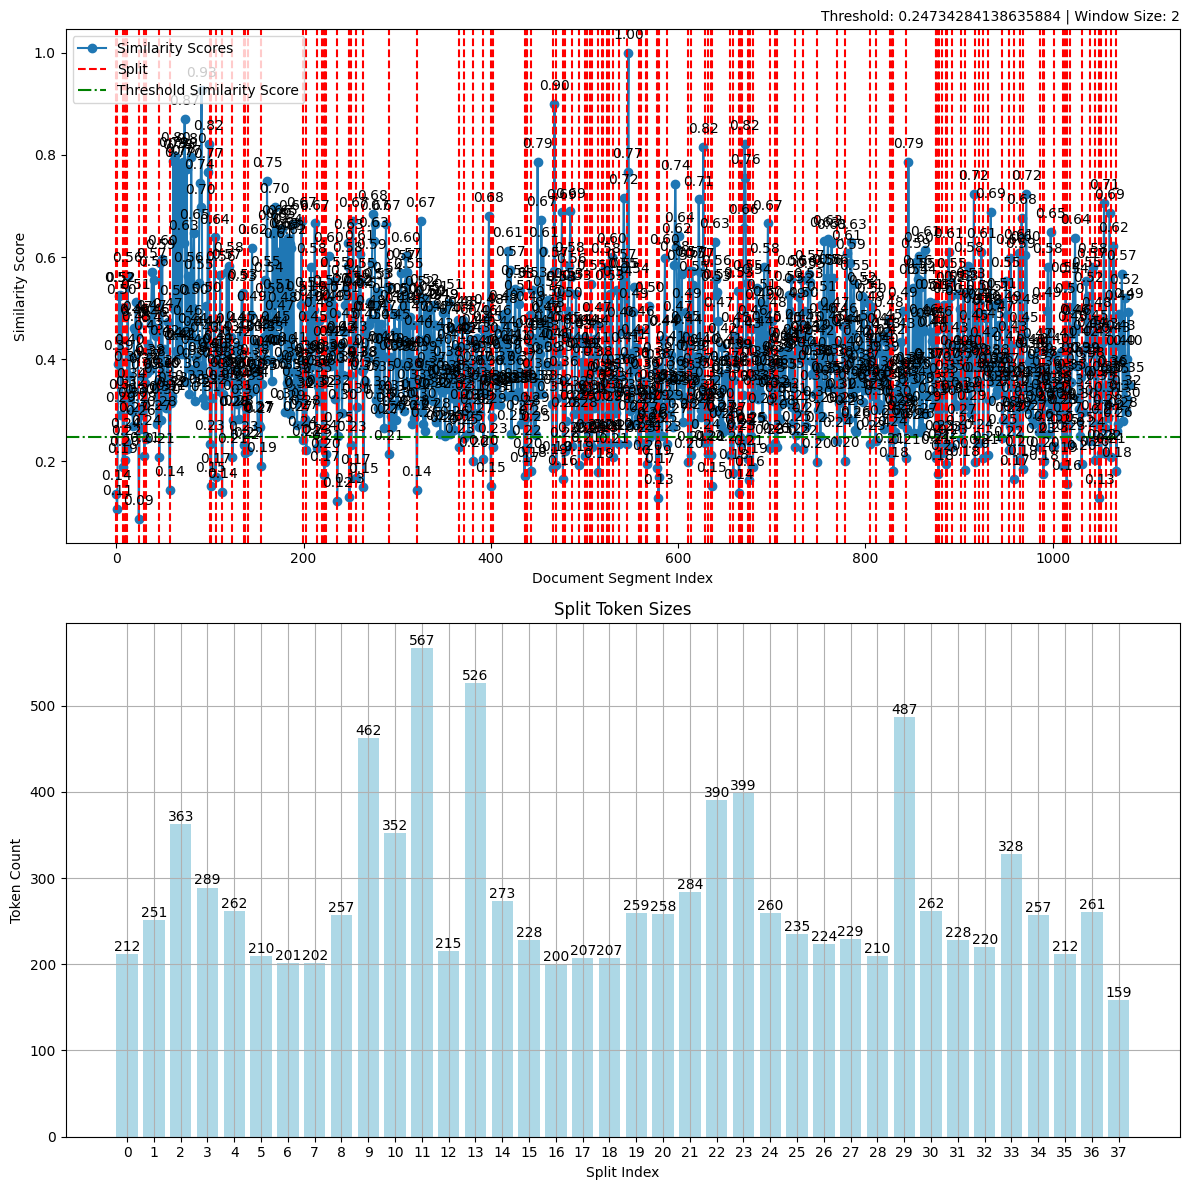

Splitting Statistics:
  - Total Documents: 1084
  - Total Splits: 38
  - Splits by Threshold: 37
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 159
  - Maximum Token Size of Split: 567
  - Similarity Split Ratio: 0.97
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
Intellectual Property Rights All Intellectual Property Rights  are reserved to members of the authorship group. No part of this publication may be reproduced or transmitted in any form  or by any means without permission in writing  from authorship group. - 3 - Ownership Ownership of the guideline will be for Committee of  Egyptian Pediatric Clinical Practice Guidelines (CEPCPG) Sponsoring Armed Forces College of Medicine (AFCM) organized a nd hosted the meetings, AFCM and the universities shared in the guideline formulation ha ve sponsored their representatives Authorship group (the Authors) & Editorial Board Printed  in June 2018 Eg

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: c6f6a1277f6f41e9ac729791b067505b


------------
1.6641323566436768
------------
{'insert_count': 38, 'ids': [12000, 12001, 12002, 12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 12021, 12022, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036, 12037], 'cost': 0}


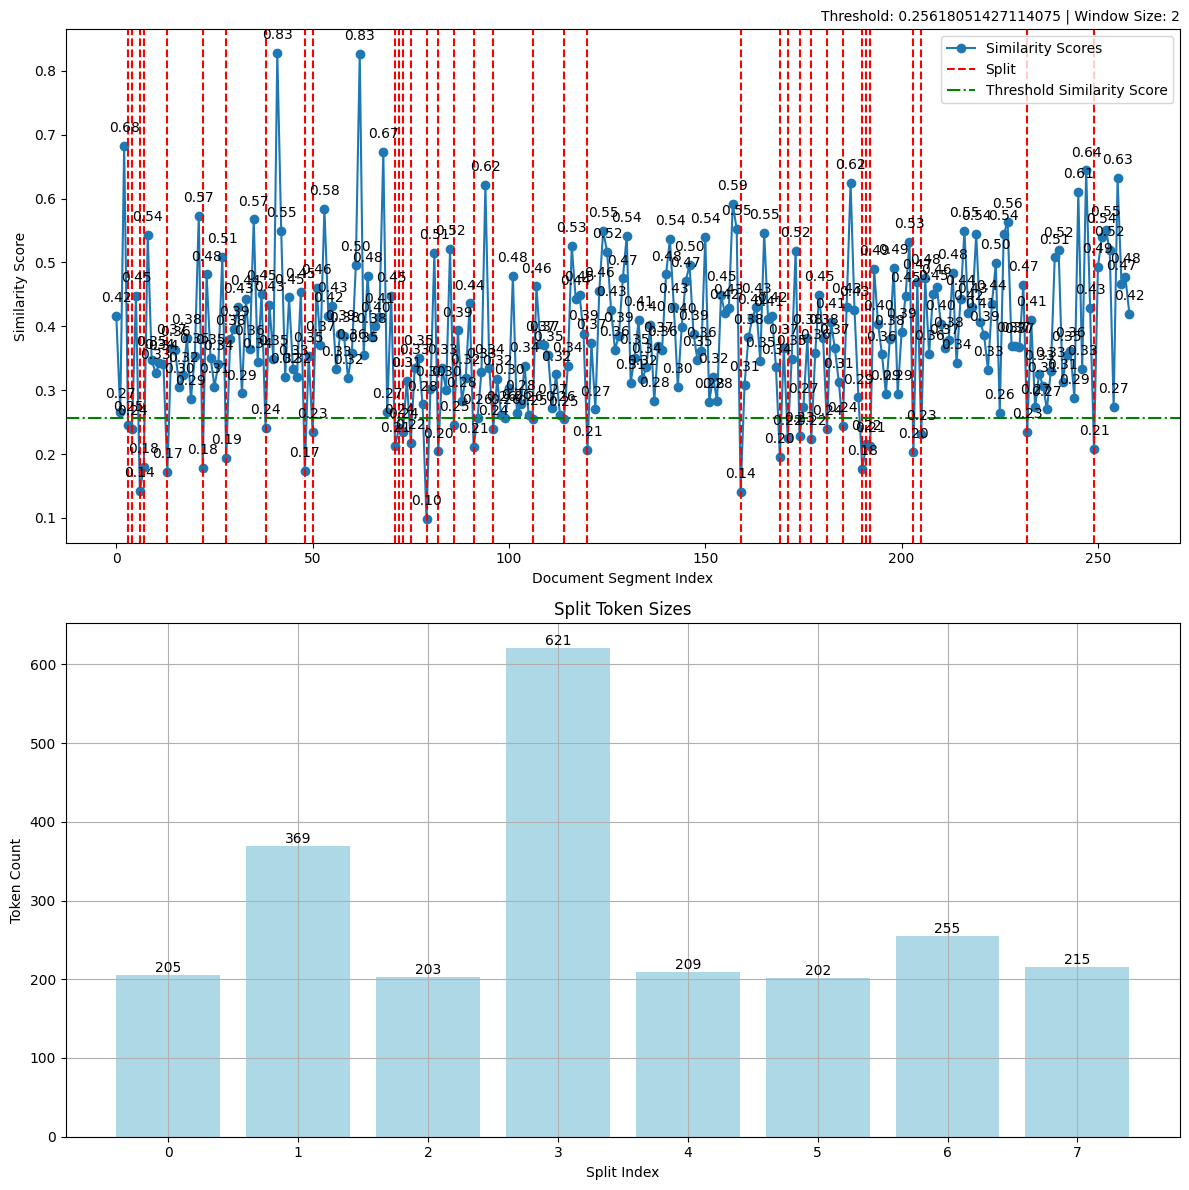

Splitting Statistics:
  - Total Documents: 260
  - Total Splits: 8
  - Splits by Threshold: 7
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 202
  - Maximum Token Size of Split: 621
  - Similarity Split Ratio: 0.88
0
1
2
3
4
5
6
7
AFCM Preface For most part s of the world , Iron Deficiency (ID) guideline recommendations are somewhat heterogeneous largely because different patient populations are addressed. The purpose of developing the Egyptian guidelines is to identify strategies and comprehensive actions needed across the  life cycle to eliminate anemia as a major public health problem among infants, young children and adolescents based on the available evidence. All Intellectual Property Rights are reserved to the authorship group. No part of this publication may be repr oduced or transmitted in any form or by any means without permission in writing from the guidelines committee members. The Authorship Group Summary of Key Recommendations Table (2

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: caf9aaac11a64e8a8a5e1a86b9ca6389


------------
1.0942955017089844
------------
{'insert_count': 8, 'ids': [13000, 13001, 13002, 13003, 13004, 13005, 13006, 13007], 'cost': 0}


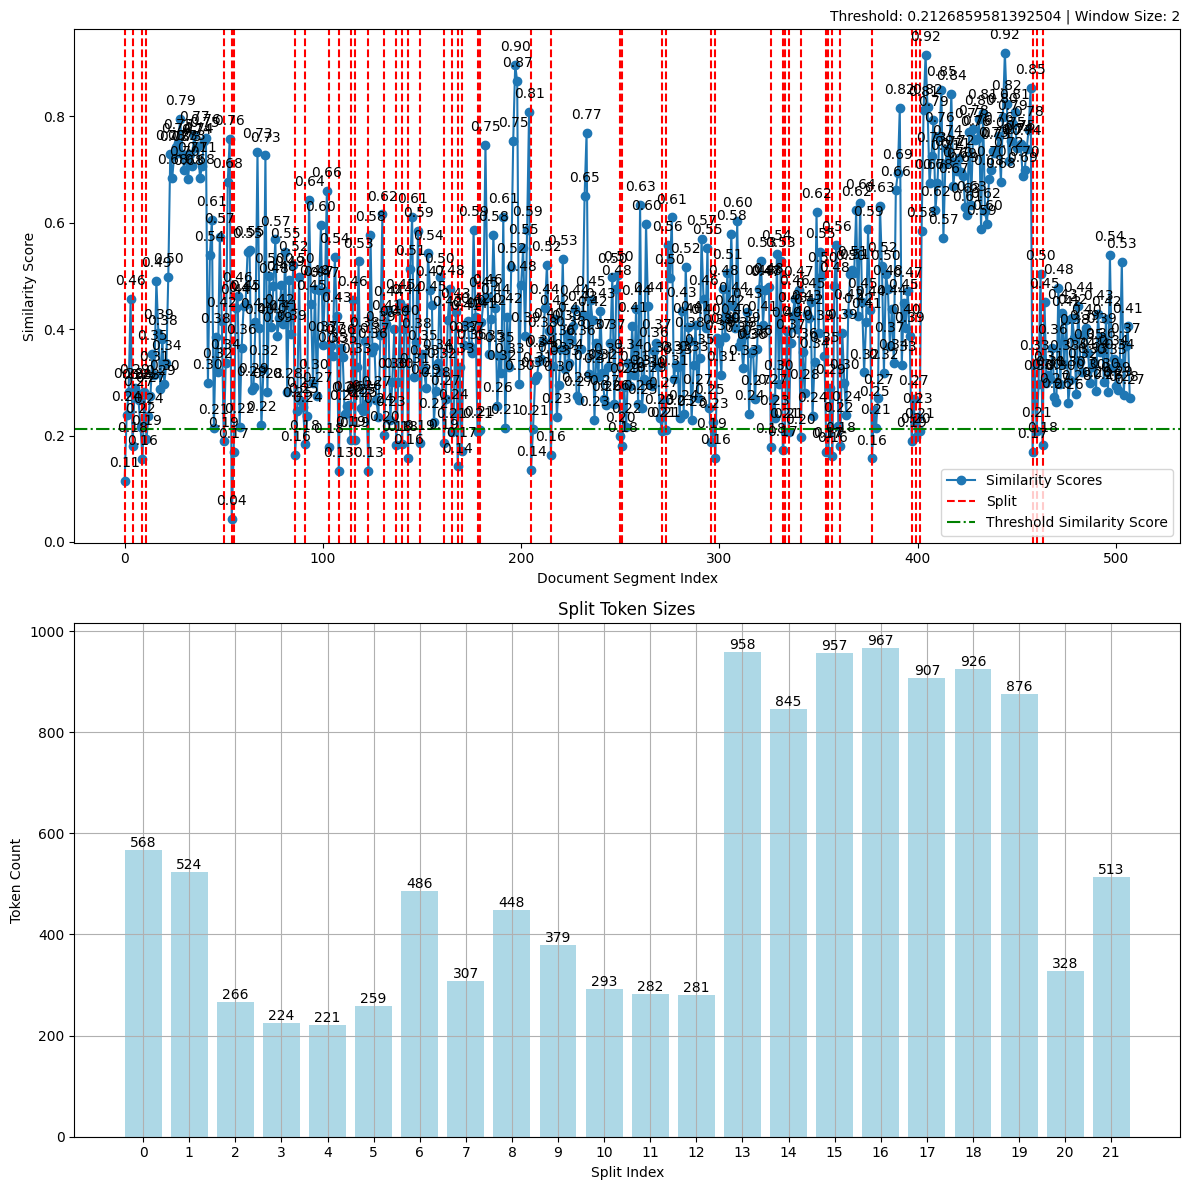

Splitting Statistics:
  - Total Documents: 509
  - Total Splits: 22
  - Splits by Threshold: 14
  - Splits by Max Chunk Size: 7
  - Last Split: 1
  - Minimum Token Size of Split: 221
  - Maximum Token Size of Split: 967
  - Similarity Split Ratio: 0.64
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
4 SUMMARY OF RECOMMENDATIONS 1. Increase awareness of mothers, during antenatal car e, about the risks of severe neonatal jaundice especially if her blood groupis Rh negative or O an d/or her indirect Coombs’ test is positive. 2. Early promotion and support of successful frequent breastfeeding. 3. Close surveillance for jaundice is essential for th e exclusive breastfed infant. Monitoring weight and hydration state (voiding and stooling) is neces saryto ensure sufficient quantity of breast milk. 4. Routine supplementation of breastfed infants with w ater or dextrose water is NOT  recommended 5. Protocols for monitoring and assessment of the risk  for severe neonatalhyperbilirubinemi

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 63a818d4322a43589137af4392fc96b9


------------
1.636033296585083
------------
{'insert_count': 22, 'ids': [14000, 14001, 14002, 14003, 14004, 14005, 14006, 14007, 14008, 14009, 14010, 14011, 14012, 14013, 14014, 14015, 14016, 14017, 14018, 14019, 14020, 14021], 'cost': 0}


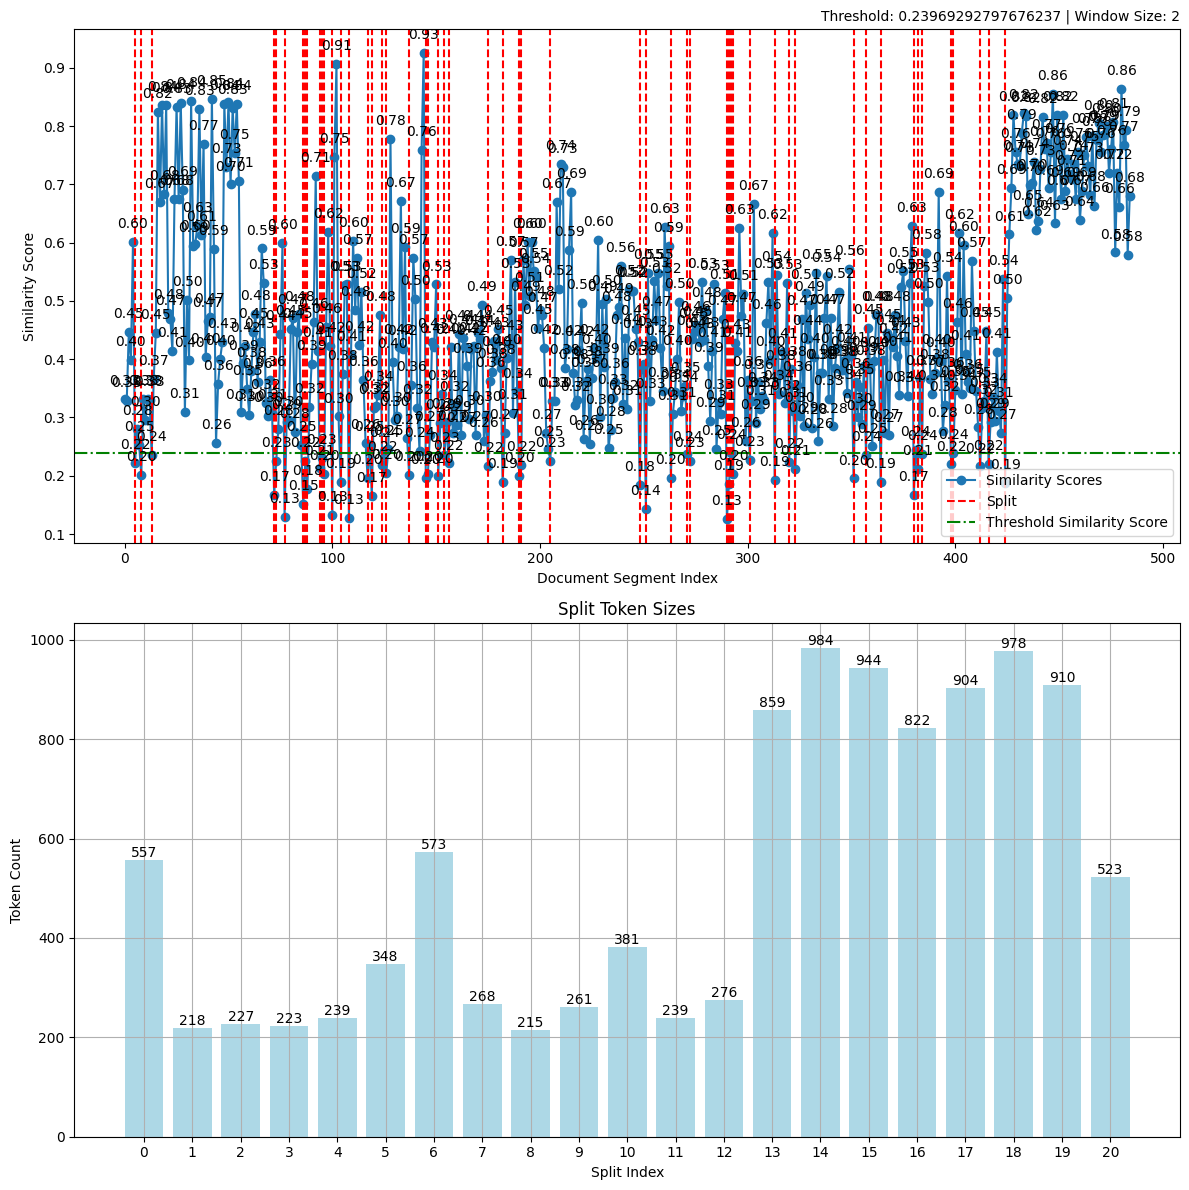

Splitting Statistics:
  - Total Documents: 486
  - Total Splits: 21
  - Splits by Threshold: 13
  - Splits by Max Chunk Size: 7
  - Last Split: 1
  - Minimum Token Size of Split: 215
  - Maximum Token Size of Split: 984
  - Similarity Split Ratio: 0.62
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
day one. 6 years and older Used in all but the mildest exacerbations • 1–2 mg/kg/day oral prednisolone for children 6–11 years up to a maximum of 40mg/day) or 200 mg hydrocortisone in  divided doses Duration (short course) Evidence A Evidence A Evidence B SIGN 1990- 2016 Ipratropium bromide • In case of moderate to severe asthma in all age groups, start with ipratropium bromide at a dose of 250ug by nebulization mixed with SABA to be repeated every 20 Evidence A minutes (for 1 hour only). GINA 1995-2018  Nebulized isotonic magnesium sulfate: • Nebulized isotonic magnesium sulfate 150 mg added to/ mixed with each nebulized salbutamol and ipratroprium bromide can be given in severe asthm

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 77a4b4e0b82d4309b901956895370519


------------
1.3793630599975586
------------
{'insert_count': 21, 'ids': [15000, 15001, 15002, 15003, 15004, 15005, 15006, 15007, 15008, 15009, 15010, 15011, 15012, 15013, 15014, 15015, 15016, 15017, 15018, 15019, 15020], 'cost': 0}


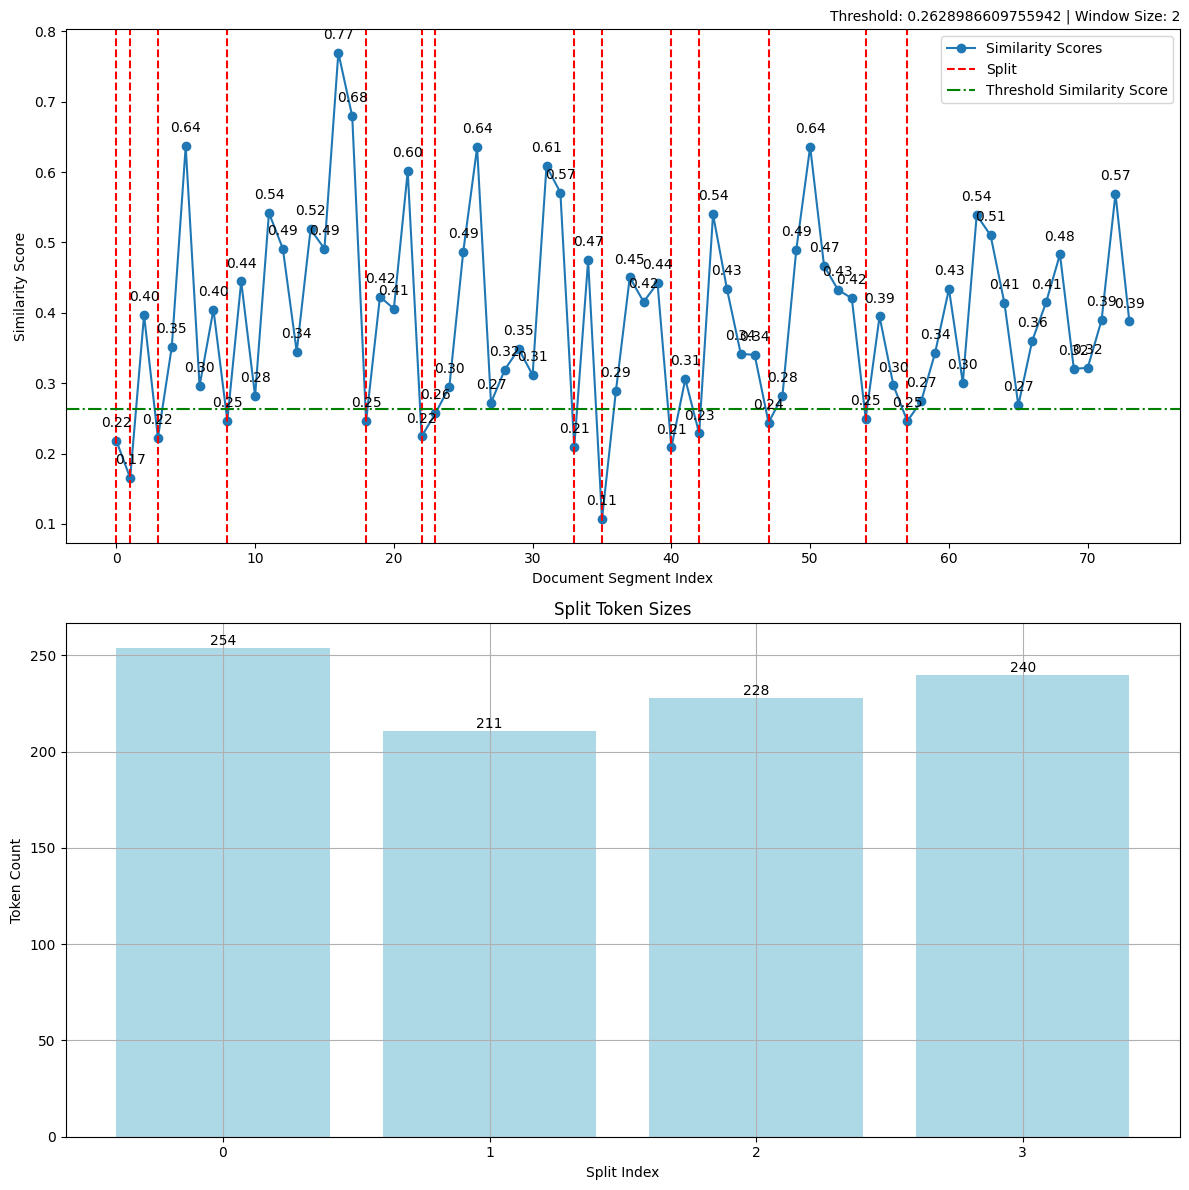

Splitting Statistics:
  - Total Documents: 75
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 211
  - Maximum Token Size of Split: 254
  - Similarity Split Ratio: 0.75
0
1
2
3
2 4. Inhaled corticosteroids: Children 6 years and older High dose ICS “ Quadrupled the patient’ ICS  low dose ” (avera ge 500 -1600 mcg BDP equivalent)  can be given within the first hour  reduce the need for hospitalization in patients not receiving systemic corticosteroids. 5. Magnesium Sulphate: Children 2 years and more • Consider nebulized isotonic Mg . sulphate  150mg 3doses  mixed with each nebulized salbutamol and ipratropium bromide  In the first h our, can be given in severe exacerbation  particularly with symptoms lasting less than 6 hours and in setting where I.V. Mg. Sulphate is not suitable . • When patients fail to respond to initial treatment,  single dose I.V Mg. Sulphate 50mg/kg infusion over  20-60 min. has been 

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 1931fe5b37254d24847b99c0ef602613


------------
0.8236093521118164
------------
{'insert_count': 4, 'ids': [16000, 16001, 16002, 16003], 'cost': 0}


In [ ]:
# Define the directory containing the PDFs
directory = '/content/drive/MyDrive/data_children'

# Get a list of all PDF files in the directory
pdf_files = glob(os.path.join(directory, '*.pdf'))
# ID index
index = 1000
# DataBase
uri=userdata.get("MILVUS_URI")
collection_name = 'child_diagnosis'
# Load each PDF file individually
for pdf_file in pdf_files:
  # index adding
  index += 1000
  # Get title
  title = os.path.splitext(os.path.basename(pdf_file))[0]
  # Create a loader for the current PDF file
  loader = PyPDFLoader(pdf_file)

  # Load the document
  document = loader.load()

  texts = " "
  for i in range(len(document)):
    texts += document[i].page_content
  # Run The Chunker
  splits = splitter([texts])

  metaData = metadata_creating_bold_head(splits,title,index)
  print(metaData[2]["content"])
  milvusData = milvusPrep(metaData, encoder)
  with open(title, 'w') as file:
    json.dump(milvusData, file)
  upload_data(collection_name,uri,milvusData)

## this is the function fetch from the vector database

In [ ]:
from pymilvus import MilvusClient, DataType
import time

def get_data(collection_name,uri,question,encoder):

  query_vectors = encoder([question])[0]
  query_vectors

  client = MilvusClient(uri)
  start = time.time()
  res = client.search(
      collection_name,     # target collection
      data=[query_vectors],
      limit=3,               # query vectors
      output_fields=['metadata','id']          # number of returned entities
  )

  end = time.time()
  search_time = end-start

  return res, search_time

In [ ]:
def build_context(text):
  cunx = ""
  for i in text[0]:
    content = i['entity']['metadata'][0]['prechunk'] + "\n\n" + \
              i['entity']['metadata'][0]['content'] + "\n\n" + \
              i['entity']['metadata'][0]['postchunk']

    cunx += f"""
    Title:{i['entity']['metadata'][0]['title']}
    ID:{i['id']}
    Content:{content}
    references:{i['entity']['metadata'][0]['references']}
    """
  return cunx